In [2]:
# Test the custom Nifti Dataset
import os
import torch
from omegaconf import OmegaConf

from wdm.configuration.files import LMDBDatasetConfig
from wdm.utils.transforms import Cropper, Resize3D
from wdm.datasets.file_based import LMDBDataset
from wdm.datasets.utils import instantiate_datasets
from wdm.utils.masking import DirectorySampler
from wdm.configuration.mask import PresampledMaskConfig
from wdm.datasets.mri import MRIMaskedDataset
from wdm.dataloaders.inpainting import MRIInpaintDataLoader
from wdm.utils.logging_tools import Session

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
# Config load
CONFIG_FILE = "wdm_inpainting/train/wdm.yaml"

config = OmegaConf.load(CONFIG_FILE)

datasets = instantiate_datasets(config.datasets)

Selected datasets:
-- IXI Dataset (Location: test_data/IXI/lmdb/volumes_T1w)
-- IXI Dataset (Location: test_data/IXI/lmdb/volumes_T1w)
-- IXI Dataset (Location: test_data/IXI/lmdb/volumes_T1w)


In [4]:
dataset_configuration = LMDBDatasetConfig(
    lmdb_folder="/Users/kingpowa/Documents/Programming/test_data/IXI/lmdb",
    is_volume=True,
    modality="T1w",
    mtransforms=[Cropper((192, 160))]
)
dataset_configuration

In [5]:
lmbd_dataset = LMDBDataset(dataset_configuration)

In [6]:
mask_sampler = DirectorySampler(PresampledMaskConfig("masks"))

In [7]:
img_shape = next(iter(lmbd_dataset))[0].shape
img_shape

(167, 192, 160)

In [8]:
opt_size = Resize3D.suggest_optimal_size(img_shape, 3.5)
opt_size

(48, 48, 48)

In [9]:
from torchvision import transforms as tf
from temp_transforms import MaskTransform

tfs = {"img": [Resize3D(opt_size, "trilinear")], "mask": [Resize3D(opt_size, "trilinear"), MaskTransform()]}

In [10]:
a = MRIMaskedDataset(lmbd_dataset, age_range=None, mask_sampler=mask_sampler)
next(iter(a))

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [11]:
mri_dataloader = MRIInpaintDataLoader(lmbd_dataset, age_range=None, mask_sampler=mask_sampler, batch_size=1, num_workers=0, transforms=tfs)
mri_dataloader.setup()
train_mri_dataloader = mri_dataloader.train_dataloader() 

In [12]:
img : torch.Tensor
mask : torch.Tensor
cond : torch.Tensor
img, mask, cond = next(iter(train_mri_dataloader))
batch = (img, mask, cond)

In [13]:
img.shape, mask.shape, cond.shape

(torch.Size([1, 1, 48, 48, 48]),
 torch.Size([1, 1, 48, 48, 48]),
 torch.Size([1, 2]))

In [14]:
batch = tuple(b.to(device) for b in batch)

In [15]:
import matplotlib.pyplot as plt

def show_image(img, slice=65):
    # Visualize the mask
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img[:,slice,...].cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

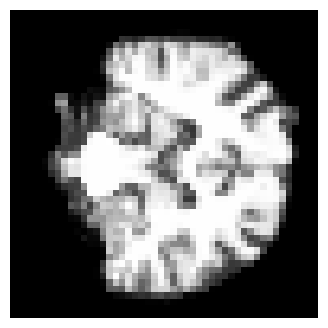

In [16]:
show_image(img[0, 0], slice = 20)

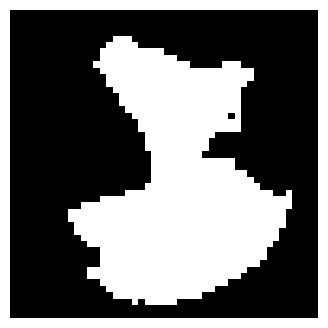

In [17]:
show_image(mask[0, 0], slice = 20)

In [18]:
from wdm.model.wdm import WDM
from wdm.model.diffusion.diffproc import SpacedDiffusion
from wdm.model.diffusion.sampler import create_named_schedule_sampler
from wdm.model.unet import UNetModel
from wdm.model.utils.etc import create_model_and_diffusion, model_and_diffusion_defaults

In [19]:
DIFFUSION_CONFIG = config.diffusion_config

In [20]:
args = model_and_diffusion_defaults(config.diffusion_config)
args["diffusion_steps"] = 50

In [21]:
args

{'image_size': 64,
 'num_channels': 128,
 'num_res_blocks': 2,
 'num_heads': 4,
 'num_heads_upsample': -1,
 'num_head_channels': -1,
 'attention_resolutions': '16,8',
 'channel_mult': '',
 'dropout': 0.0,
 'use_checkpoint': False,
 'use_scale_shift_norm': False,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'dims': 3,
 'num_groups': 32,
 'in_channels': 8,
 'out_channels': 0,
 'bottleneck_attention': True,
 'resample_2d': False,
 'additive_skips': False,
 'mode': 'default',
 'predict_xstart': False,
 'use_conditional_model': None,
 'learn_sigma': False,
 'diffusion_steps': 50,
 'noise_schedule': 'linear',
 'timestep_respacing': '',
 'use_kl': False,
 'rescale_timesteps': False,
 'rescale_learned_sigmas': False}

In [22]:
model, diffusion = create_model_and_diffusion(**args)

In [23]:
model = model.to(device)

In [24]:
sampler = create_named_schedule_sampler("uniform", diffusion,  maxt=args["diffusion_steps"])

In [25]:
wdm = WDM(
    model=model,
    diffusion=diffusion,
    batch_size=1,
    in_channels=1,
    microbatch=-1,
    lr=1e-03,
    log_interval=10,
    img_log_interval=10,
    schedule_sampler=sampler,
    mode="Conditional_always_known_only_healthy",
    label_cond_weight=0
).to(device)

Logging to ./results
Training requires CUDA.


In [26]:
wdm.configure_optimizers()

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)

In [27]:
batch

(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           ...,
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]

In [28]:
session = Session("WDM", config)

In [29]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from wdm.utils.logging_tools import AdvancedWandLogger

wand_logger = AdvancedWandLogger(model, session)

# Define the trainer
trainer = Trainer(
    max_steps=50000,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[ModelCheckpoint(dirpath=session.working_directory, monitor="loss/MSE", save_top_k=1)],
    logger=wand_logger
)

# Train the model
trainer.fit(wdm, datamodule=mri_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/kingpowa/miniconda3/envs/ai-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/kingpowa/miniconda3/envs/ai-env/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
wandb: Currently logged in as: kingpowaalias (kingpowaalias-universitatsklinikumtubingen). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/Users/kingpowa/miniconda3/envs/ai-env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/kingpowa/Documents/Programming/wdm_training/WDM_exec_1737390504.020138 exists and is not empty.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | UNetModel | 251 M  | train
--------------------------------------------
251 M     Trainable params
0         Non-trainable params
251 M     Total params
1,005.257 Total estimated model params size (MB)
524       Modules in train mode
0         Modules in eval mode
/Users/kingpowa/miniconda3/envs/ai-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined